## 1. Real-world Datasets

* Yoochoose
* MovieLens

### 1.1 Preprocess Yoochoose

Preprocessing:

In [1]:
# encode user(sessions) and items
from data_extract import encode_yoochoose
encode_yoochoose()

Original feature shape
Train: (273557, 5)
Val: (14398, 5)
Test: (15155, 5)
Unique items: 2
Unique users: 206036


 12%|█▏        | 30234/248999 [00:00<00:00, 302294.88it/s]

New feature shape
Train: (248999, 5)
Val: (26966, 5)
Test: (27145, 5)


100%|██████████| 27145/27145 [00:00<00:00, 750973.77it/s]


Unique items: 10098
Unique users: 206036


In [2]:
# balance number of click
from data_extract import balance_n_click, DATA_ROOT
import pickle
train = pickle.load(open(DATA_ROOT + "yoochoose-data/encoded_train.pkl", 'rb'))
slates, users, responses = balance_n_click(train["features"], train["sessions"], train["responses"])
pickle.dump({"features": slates, "sessions": users, "responses": responses}, \
            open(DATA_ROOT + "yoochoose-data/encoded_train.pkl", 'wb'))

  0%|          | 0/34428 [00:00<?, ?it/s]

Before augmentation: 
(array([0., 1., 2., 3., 4., 5.]), array([26673, 95529, 70332, 35962, 15486,  5017]))
Augmenting data for #click == 0
Number of new record: 34428


100%|██████████| 34428/34428 [00:00<00:00, 106584.00it/s]
0it [00:00, ?it/s]
  0%|          | 0/29783 [00:00<?, ?it/s]

Augmenting data for #click == 1
Number of new record: 0
Augmenting data for #click == 2
Number of new record: 12598
Augmenting data for #click == 3
Number of new record: 29783


 25%|██▍       | 9808/40021 [00:00<00:00, 98066.53it/s]

Augmenting data for #click == 4
Number of new record: 40021


 28%|██▊       | 12675/45256 [00:00<00:00, 126732.29it/s]

Augmenting data for #click == 5
Number of new record: 45256


100%|██████████| 45256/45256 [00:00<00:00, 133948.55it/s]


After augmentation: 
(array([0., 1., 2., 3., 4., 5.]), array([61101, 95529, 82930, 65745, 55507, 50273]))


In [3]:
# construct single dataset 'entire' for training response model
import pickle
train = pickle.load(open(DATA_ROOT + "yoochoose-data/encoded_train.pkl", 'rb'))
val = pickle.load(open(DATA_ROOT + "yoochoose-data/encoded_val.pkl", 'rb'))
test = pickle.load(open(DATA_ROOT + "yoochoose-data/encoded_test.pkl", 'rb'))
import numpy as np
pickle.dump({"features": np.concatenate([train["features"], val["features"], test["features"]], axis = 0), \
             "sessions": np.concatenate([train["sessions"], val["sessions"], test["sessions"]], axis = 0), \
             "responses": np.concatenate([train["responses"], val["responses"], test["responses"]], axis = 0)}, \
            open(DATA_ROOT + "yoochoose-data/encoded_entire.pkl", 'wb'))

### 1.2 MovieLens

Preprocessing: balance_n_click

2393it [00:00, 229327.34it/s]
2393it [00:00, 880127.10it/s]
2393it [00:00, 299978.17it/s]
19633it [00:00, 261842.25it/s]
19633it [00:00, 957888.15it/s]
0it [00:00, ?it/s]

Load data from "../data/movielens/test_slate.csv"
Load data from "../data/movielens/test_user.csv"
Load data from "../data/movielens/test_resp.csv"
Load data from "../data/movielens/entire_slate.csv"
Load data from "../data/movielens/entire_user.csv"
Load data from "../data/movielens/entire_resp.csv"


19633it [00:00, 297788.18it/s]


dir "results" existed


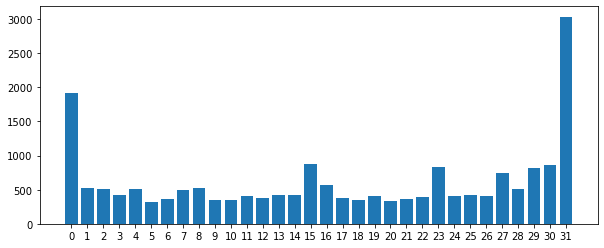

In [1]:
import data_extract as dae
trainset, valset = dae.read_movielens(entire = True)
from plot import plot_slate_response_distribution
%matplotlib inline
plot_slate_response_distribution(trainset["responses"])

In [3]:
from data_extract import balance_n_click
slates, users, responses = balance_n_click(trainset["features"], trainset["sessions"], trainset["responses"])

100%|██████████| 312/312 [00:00<00:00, 61704.21it/s]
0it [00:00, ?it/s]
100%|██████████| 614/614 [00:00<00:00, 55594.47it/s]

Before augmentation: 
(array([0, 1, 2, 3, 4, 5]), array([1919, 2642, 3640, 4265, 4131, 3036]))
Augmenting data for #click == 0
Number of new record: 1173
Augmenting data for #click == 1
Number of new record: 811
Augmenting data for #click == 2
Number of new record: 312
Augmenting data for #click == 3
Number of new record: 0
Augmenting data for #click == 4
Number of new record: 67
Augmenting data for #click == 5
Number of new record: 614
After augmentation: 
(array([0., 1., 2., 3., 4., 5.]), array([3092, 3453, 3952, 4265, 4198, 3650]))


## 2. Simulation Environments

Recommendation test environment is provided as user response model p(r|s):

* urm: plain user response model
* urm_p: urm with item positional bias
* urm_p_mr: urm_p with multi-item relations


### 2.1 Create Simulation Environment

In [1]:
import argparse
import data_extract as dae
parser = argparse.ArgumentParser()
parser = dae.add_sim_parse(parser)
parser = dae.add_data_parse(parser)
args = parser.parse_args("")

args.n_user = 1000
args.n_item = 3000
args.dataset = "urmpmr"
args.pbias_min = -0.1
args.pbias_max = 0.1
args.mr_factor = 0.3
# args.balance = True
print(args)

Namespace(balance=False, dataset='urmpmr', mr_factor=0.3, n_item=3000, n_test=10000, n_train=100000, n_user=1000, n_val=10000, nouser=False, pbias_max=0.1, pbias_min=-0.1, s=5, sim_dim=8, sim_root=False)


In [2]:
from my_utils import Logger
logger = Logger("log/sim.txt")
simulator, trainset, valset = dae.load_simulation(args, logger)

dir "log" existed
Log file path:
log/sim.txt+++++++++++++++++++++++
Construct simulation data
	device: cpu
	Creating document latent embedding
		Doc embedding sample: tensor([-0.2238, -0.2920, -0.3232, -0.2132,  0.3595, -0.0097,  0.2984,  0.4330],
       grad_fn=<SelectBackward>)
	Creating user latent embedding
		User embedding sample: tensor([-0.0508,  0.4014,  0.3101,  0.4193,  0.1632, -0.0249, -0.4665,  0.1705],
       grad_fn=<SelectBackward>)
generating training set


  0%|          | 0/30010 [00:00<?, ?it/s]

Guarantee min_user_hist requirement:
Guarantee min_item_hist requirement:


 31%|███       | 18688/59980 [00:00<00:00, 185723.58it/s]

Generate the remaining data


100%|██████████| 59980/59980 [00:00<00:00, 169501.42it/s]

Number of click distribution: (array([0, 1, 2, 3, 4, 5]), array([  535,  5767, 16061, 21190, 13228,  3199]))
Initialize dataset
Slates shape: (100000, 5)
Users shape: (100000,)
Response shape: (100000, 5)
Unique items: 3001
Unique users: 1001
User embedding is used
generating validation set



100%|██████████| 5998/5998 [00:00<00:00, 157371.67it/s]

Guarantee min_user_hist requirement:
Guarantee min_item_hist requirement:
Generate the remaining data
Number of click distribution: (array([0, 1, 2, 3, 4, 5]), array([  46,  584, 1605, 2111, 1342,  310]))
Initialize dataset
Slates shape: (10000, 5)
Users shape: (10000,)
Response shape: (10000, 5)
Unique items: 3001
Unique users: 1001
User embedding is used
save simulator and generated datasets


### 2.2 Simulation Distribution Made Similar to That of Real-world Data

Run 2.1 with balance=True or run the following after running 2.1 with balance=False:

dir "results" existed


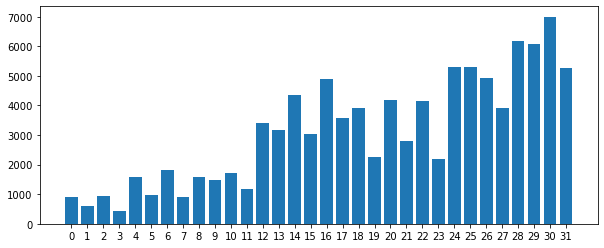

In [3]:
from plot import plot_slate_response_distribution
%matplotlib inline
plot_slate_response_distribution(trainset.responses)

In [4]:
from data_loader import UserSlateResponseDataset
trainset = UserSlateResponseDataset(trainset.slates, trainset.users, trainset.responses, args.nouser)
trainset.balance_n_click()

  0%|          | 0/12830 [00:00<?, ?it/s]

Initialize dataset
Slates shape: (100000, 5)
Users shape: (100000, 1)
Response shape: (100000, 5)
Unique items: 3001
Unique users: 1001
User embedding is used
Before augmentation: 
(array([0., 1., 2., 3., 4., 5.]), array([  906,  9578, 26780, 35239, 22224,  5273]))
Augmenting data for #click == 0
Number of new record: 17166
Augmenting data for #click == 1
Number of new record: 12830


100%|██████████| 4229/4229 [00:00<00:00, 119688.47it/s]
0it [00:00, ?it/s]
  0%|          | 0/14983 [00:00<?, ?it/s]

Augmenting data for #click == 2
Number of new record: 4229
Augmenting data for #click == 3
Number of new record: 0
Augmenting data for #click == 4
Number of new record: 6507
Augmenting data for #click == 5
Number of new record: 14983


100%|██████████| 14983/14983 [00:00<00:00, 82924.39it/s]


After augmentation: 
(array([0., 1., 2., 3., 4., 5.]), array([18072, 22408, 31009, 35239, 28731, 20256]))
Number of records: 155715


dir "results" existed


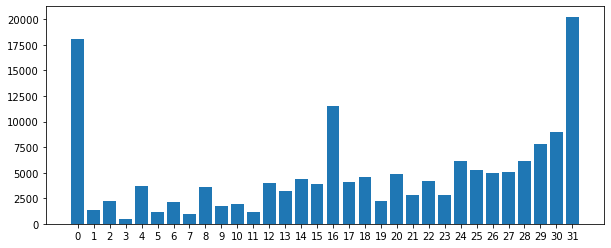

In [5]:
%matplotlib inline
plot_slate_response_distribution(trainset.responses)

### 2.3 Generate More Datasets from Simulator

Run 2.1 first, then run:

In [6]:
users, slates, responses = simulator.generate_dataset(min_user_hist = 10, min_item_hist = 10, n_record = args.n_train)

  0%|          | 0/30010 [00:00<?, ?it/s]

Guarantee min_user_hist requirement:
Guarantee min_item_hist requirement:


 25%|██▍       | 14976/59980 [00:00<00:00, 149011.94it/s]

Generate the remaining data


100%|██████████| 59980/59980 [00:00<00:00, 138542.97it/s]

Number of click distribution: (array([0, 1, 2, 3, 4, 5]), array([  534,  5613, 15966, 21369, 13395,  3103]))


### 2.4 Directly Interact with the Environment

In [7]:
import torch
import numpy as np
slates = torch.tensor([np.arange(5), np.arange(5)+5, np.arange(5)+10, np.arange(5)+15])
users = torch.tensor([0,1,2,4])
simulator.forward(slates, users)

tensor([[0.4475, 0.4189, 0.3619, 0.3825, 0.4109],
        [0.6587, 0.5504, 0.3752, 0.8137, 0.4745],
        [0.2670, 0.4182, 0.5624, 0.2035, 0.5300],
        [0.6893, 0.3789, 0.0226, 0.3548, 0.7511]], grad_fn=<AddBackward0>)

In [8]:
simulator.generate_response_for_dataset(users, slates)

100%|██████████| 4/4 [00:00<00:00, 1418.55it/s]


tensor([[0, 0, 0, 0, 0],
        [1, 1, 0, 1, 0],
        [0, 0, 1, 0, 1],
        [1, 0, 0, 0, 1]])